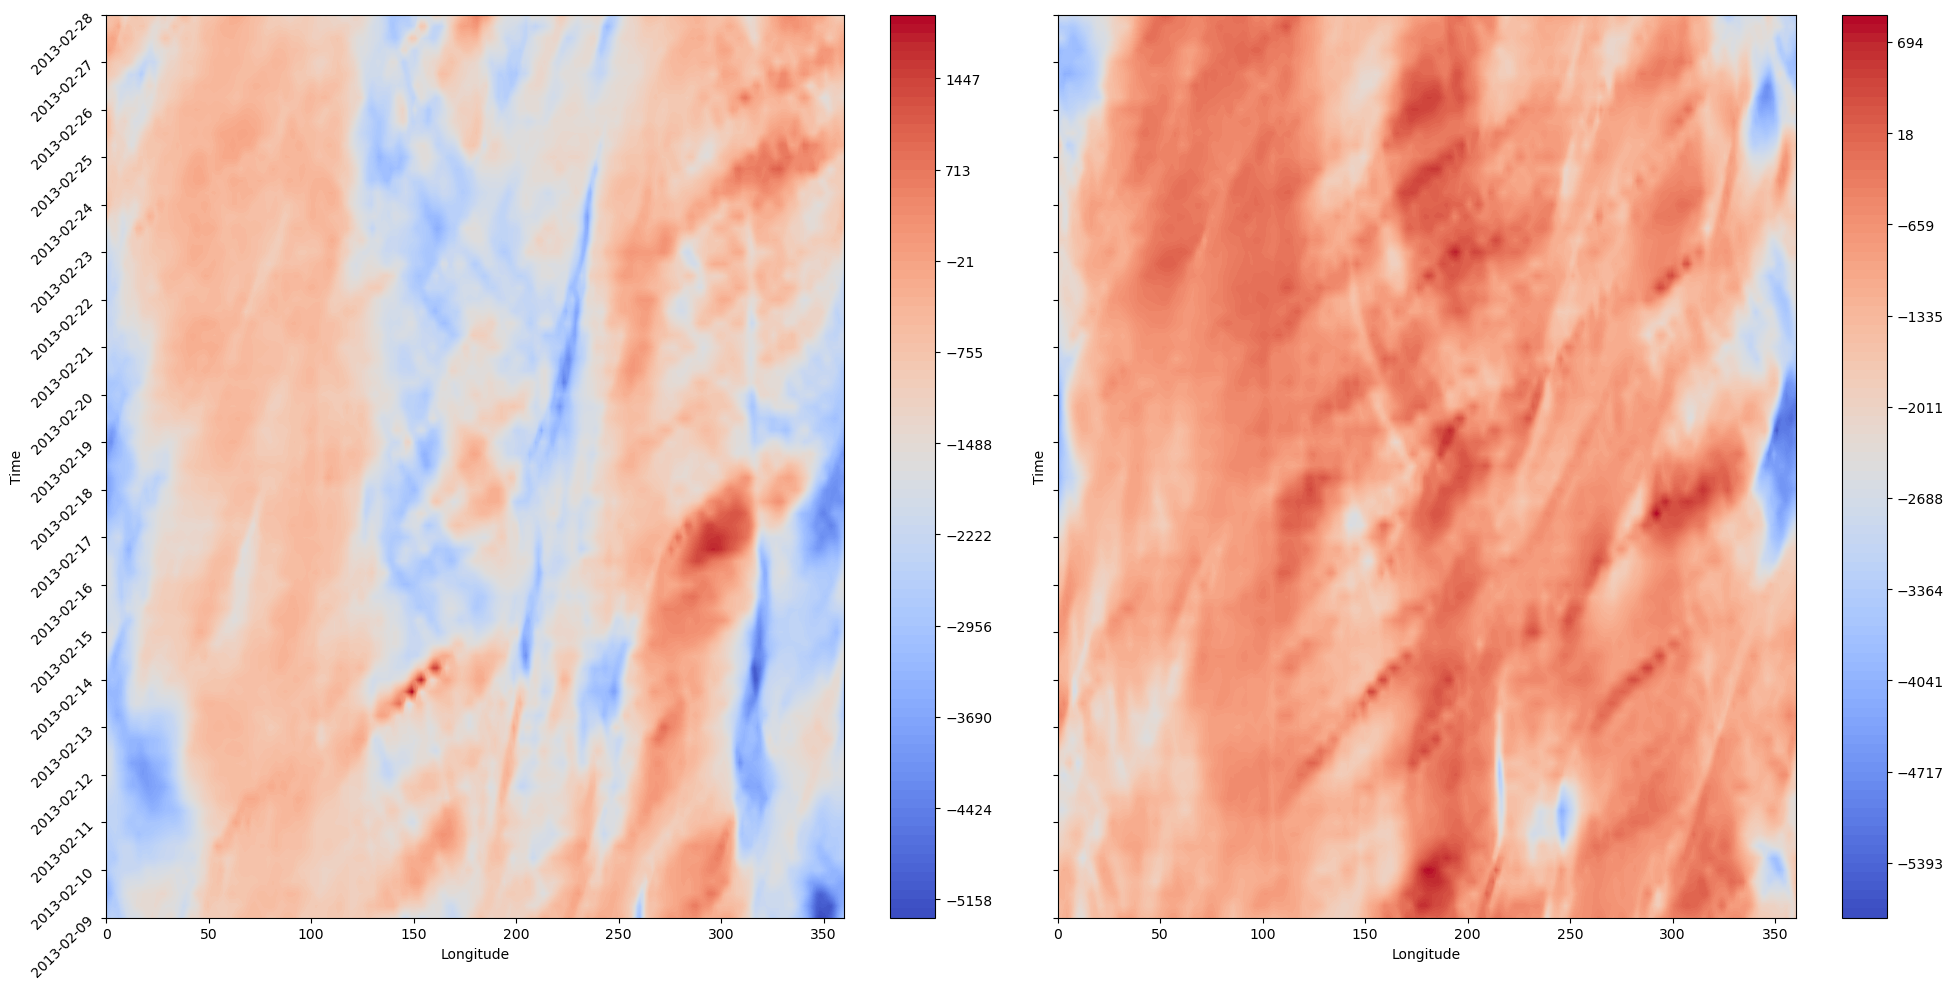

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            # return time_stamp, np.clip(total_flux, -1000, 2000)
            return time_stamp, total_flux
    return None, None

def plot_flux_difference_heatmap(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Flux Difference: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='Flux Difference')

def plot_total_flux(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 0, 90], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Total LWA Flux: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='LWA Flux')

    
def plot_flux(flux_difference, time_stamp, ax, flux_label):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap='coolwarm')
    ax.set_title(f'{flux_label}: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label=flux_label)

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')
    
    # Collect all valid files once
    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]
    
    # Define two time ranges for Y-axis (6-hour intervals)
    time_ranges = [
        (datetime(2013, 1, 10), datetime(2013, 1, 29)),
        (datetime(2013, 2, 9), datetime(2013, 2, 28))
    ]
    time_delta = timedelta(hours=6)
    
    # Setup the figure and axes for the two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
    
    for ax, (start_time, end_time) in zip(axs, time_ranges):
        times = [start_time + i*time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes
        
        for i, time_point in enumerate(times):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros_like(flux_capacity_2d)
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                if np.any(total_flux):
                    flux_difference = total_flux - flux_capacity_2d
                    nh_avg_flux = np.mean(flux_difference[80:101, :], axis=0)
                    hovmoller_data[i, :] = nh_avg_flux

        # Plotting the Hovmöller diagram for each subplot
        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        levels = np.linspace(np.min(hovmoller_data), np.max(hovmoller_data), 100)  # Adjust for smoother gradients
        c = ax.contourf(X, Y, hovmoller_data, levels=levels, cmap='coolwarm')
        fig.colorbar(c, ax=ax)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Time')

        # Adjust y-ticks and y-tick labels to fit within each subplot's time range
        yticks = np.arange(0, len(times), 4)  # Adjust based on preference or clarity
        ax.set_yticks(yticks)
        ax.set_yticklabels([times[tick].strftime('%Y-%m-%d') for tick in yticks], rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


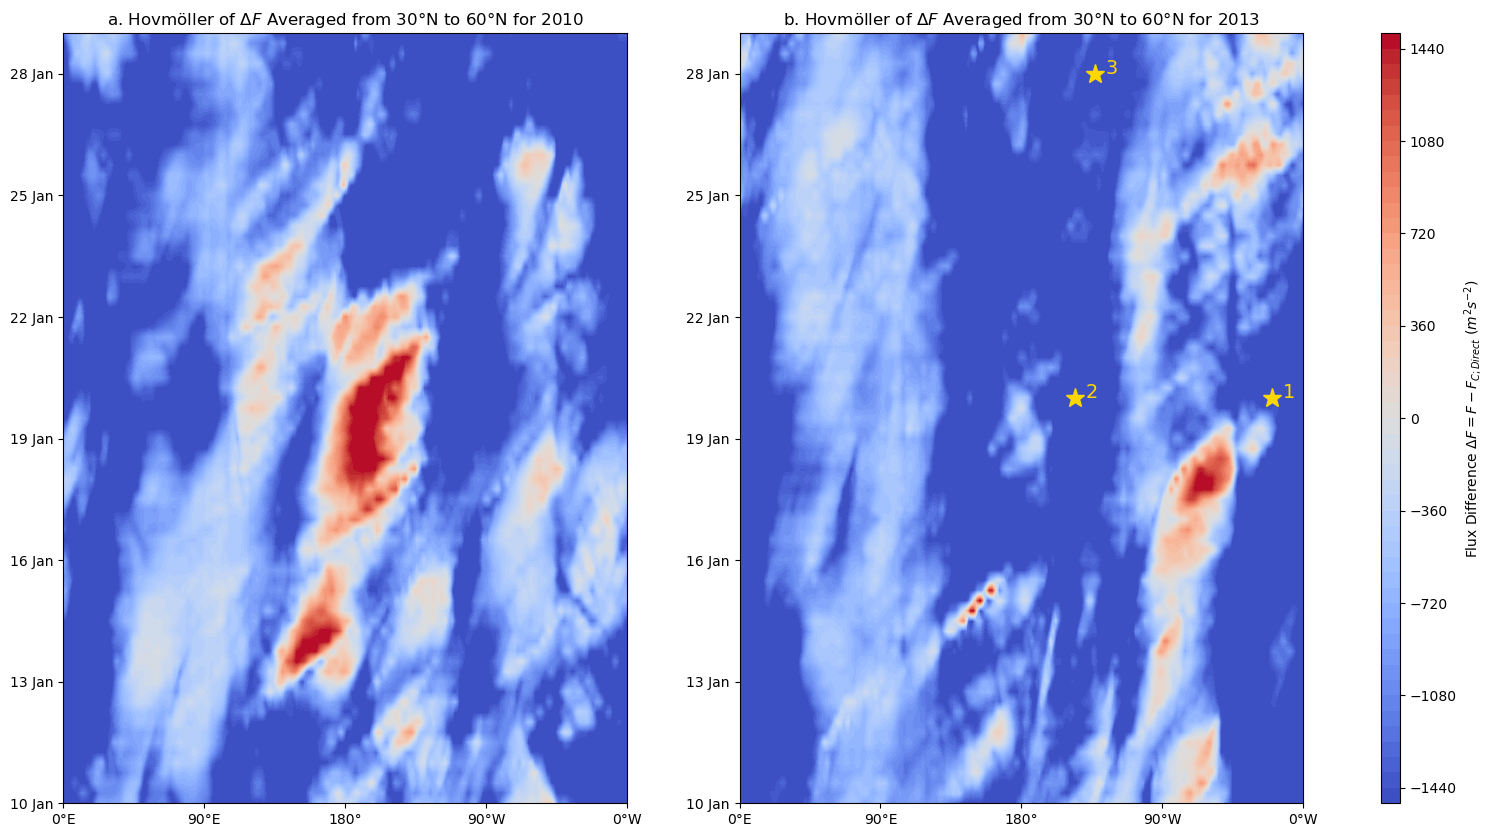

In [18]:
# 0409 version fig 3 

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

# Combine NH and SH blocking data and filter
blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            # return time_stamp, np.clip(total_flux, -1000, 2000)
            return time_stamp, total_flux
    return None, None

def plot_flux_difference_heatmap(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Flux Difference: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='Flux Difference')

def plot_total_flux(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 0, 90], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Total LWA Flux: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='LWA Flux')

    
def plot_flux(flux_difference, time_stamp, ax, flux_label):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap='coolwarm')
    ax.set_title(f'{flux_label}: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label=flux_label)

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')
    
    # Collect all valid files once
    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]
    
    # Define two time ranges for Y-axis (6-hour intervals)
    time_ranges = [
        (datetime(2010, 1, 10), datetime(2010, 1, 29)),
        (datetime(2013, 1, 10), datetime(2013, 1, 29))
    ]
    time_delta = timedelta(hours=6)
    
    # Setup the figure and axes for the two subplots without sharing y-axis
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    last_contour = None  # Placeholder for the last contour object
    
    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes
        
        for i, time_point in enumerate(times):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros_like(flux_capacity_2d)
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                if np.any(total_flux):
                    flux_difference = total_flux - flux_capacity_2d
                    nh_avg_flux = np.mean(flux_difference[80:101, :], axis=0)
                    hovmoller_data[i, :] = nh_avg_flux
        hovmoller_data = np.clip(hovmoller_data, -1500, 1500)

        # Plotting the Hovmöller diagram for each subplot
        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        levels = np.linspace(-1500, 1500, 51)
        last_contour = ax.contourf(X, Y, hovmoller_data, levels=levels, cmap='coolwarm', vmin=-1500, vmax=1500)
        
        # Set x-axis labels to specific longitudes
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        
        # Dynamic title setting
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of $\\Delta F$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")
   

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

    # Create a colorbar on the right side of the figure, associated with the last subplot
    fig.colorbar(last_contour, ax=axs, location='right', aspect=40, label=r'Flux Difference $\Delta F = F - F_{C; Direct}$ ($m^2s^{-2}$)')
    
    # Specify the file path and name where you want to save the figure
    save_path = '/depot/wanglei/etc/KenYan_Traffic_Model/fig3ver0409.png'
    
    # Save the figure
    plt.savefig(save_path, dpi=300) 
    
    # plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



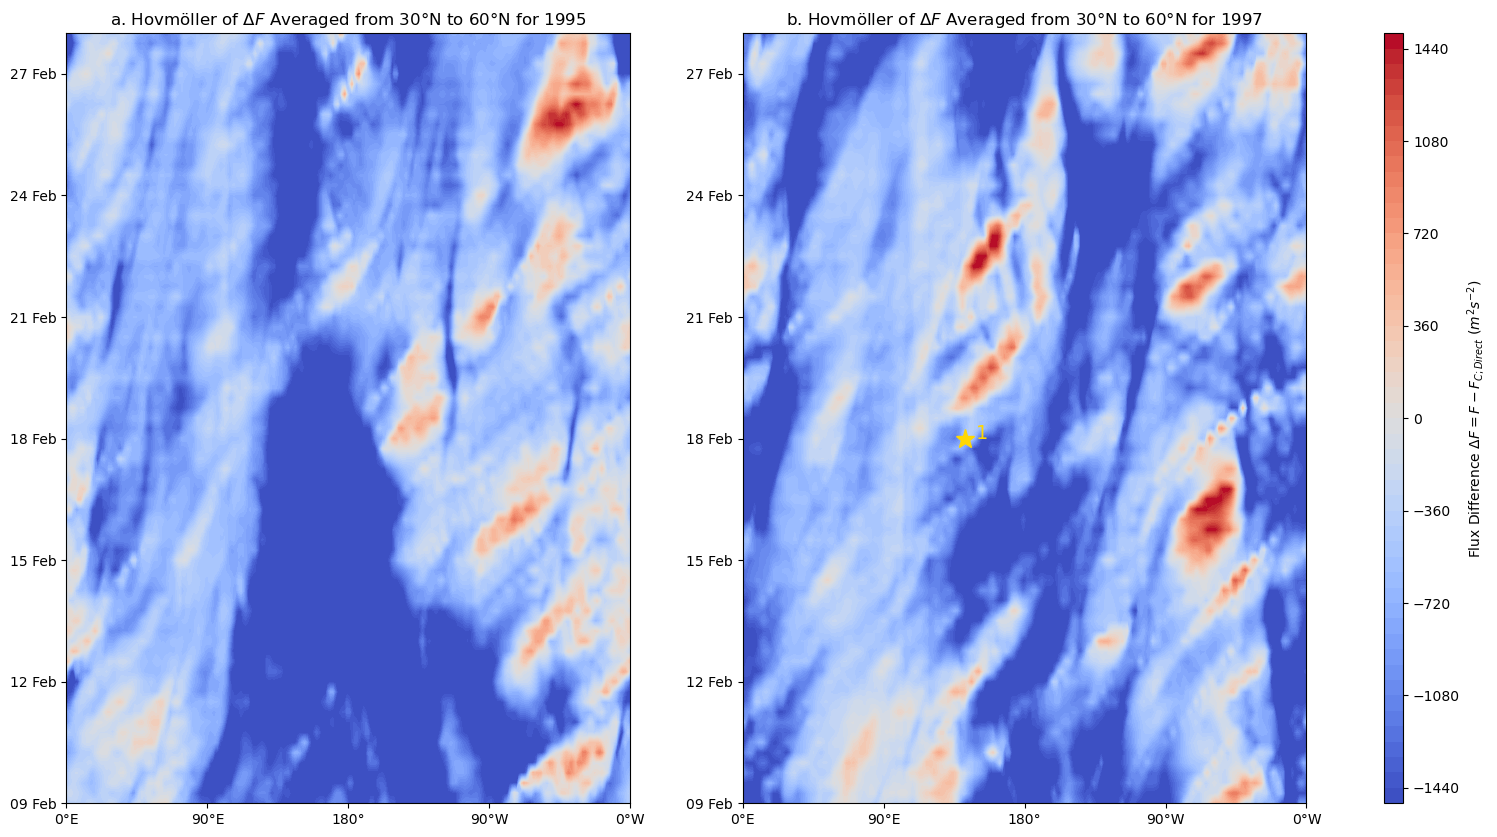

In [17]:
# other timestamps

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

# Combine NH and SH blocking data and filter
blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            # return time_stamp, np.clip(total_flux, -1000, 2000)
            return time_stamp, total_flux
    return None, None

def plot_flux_difference_heatmap(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Flux Difference: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='Flux Difference')

def plot_total_flux(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 0, 90], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Total LWA Flux: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='LWA Flux')

    
def plot_flux(flux_difference, time_stamp, ax, flux_label):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap='coolwarm')
    ax.set_title(f'{flux_label}: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label=flux_label)

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')
    
    # Collect all valid files once
    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]
    
    # Define two time ranges for Y-axis (6-hour intervals)
    time_ranges = [
        (datetime(1995, 2, 9), datetime(1995, 2, 28)),
        (datetime(1997, 2, 9), datetime(1997, 2, 28))
    ]
    time_delta = timedelta(hours=6)
    
    # Setup the figure and axes for the two subplots without sharing y-axis
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    last_contour = None  # Placeholder for the last contour object
    
    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes
        
        for i, time_point in enumerate(times):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros_like(flux_capacity_2d)
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                if np.any(total_flux):
                    flux_difference = total_flux - flux_capacity_2d
                    nh_avg_flux = np.mean(flux_difference[80:101, :], axis=0)
                    hovmoller_data[i, :] = nh_avg_flux
        hovmoller_data = np.clip(hovmoller_data, -1500, 1500)

        # Plotting the Hovmöller diagram for each subplot
        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        levels = np.linspace(-1500, 1500, 51)
        last_contour = ax.contourf(X, Y, hovmoller_data, levels=levels, cmap='coolwarm', vmin=-1500, vmax=1500)
        
        # Set x-axis labels to specific longitudes
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        
        # Dynamic title setting
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of $\\Delta F$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")
   

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

    # Create a colorbar on the right side of the figure, associated with the last subplot
    fig.colorbar(last_contour, ax=axs, location='right', aspect=40, label=r'Flux Difference $\Delta F = F - F_{C; Direct}$ ($m^2s^{-2}$)')
    
    # plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



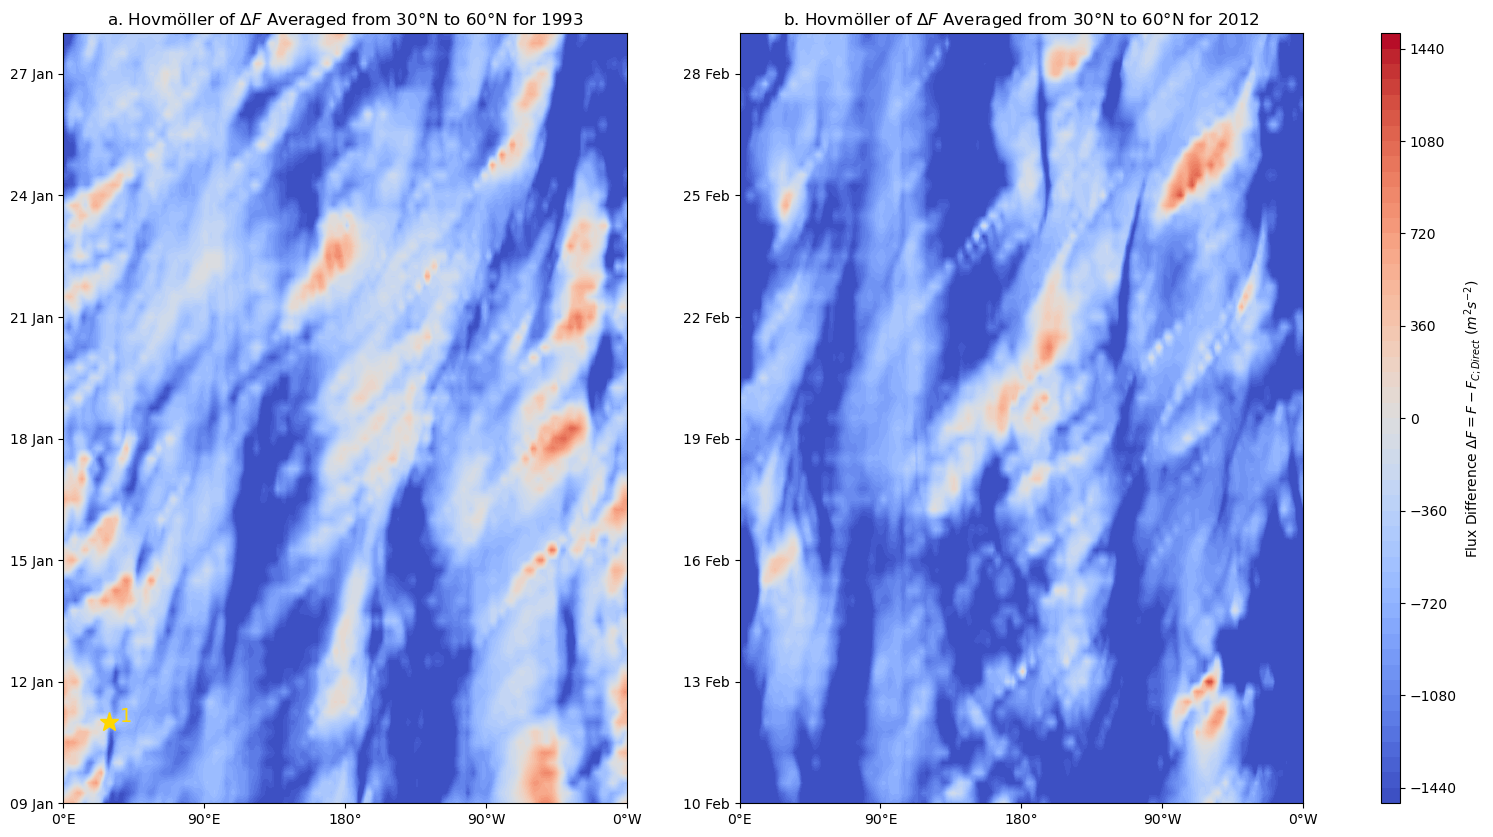

In [15]:
# other time stamps

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

# Combine NH and SH blocking data and filter
blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            # return time_stamp, np.clip(total_flux, -1000, 2000)
            return time_stamp, total_flux
    return None, None

def plot_flux_difference_heatmap(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Flux Difference: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='Flux Difference')

def plot_total_flux(flux_difference, time_stamp, ax):
    im = ax.imshow(flux_difference, extent=[0, 360, 0, 90], origin='lower', aspect='auto', cmap = 'coolwarm')
    ax.set_title(f'Total LWA Flux: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='LWA Flux')

    
def plot_flux(flux_difference, time_stamp, ax, flux_label):
    im = ax.imshow(flux_difference, extent=[0, 360, 30, 60], origin='lower', aspect='auto', cmap='coolwarm')
    ax.set_title(f'{flux_label}: {time_stamp}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label=flux_label)

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')
    
    # Collect all valid files once
    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]
    
    # Define two time ranges for Y-axis (6-hour intervals)
    time_ranges = [
        (datetime(1993, 1, 9), datetime(1993, 1, 28)),
        (datetime(2012, 2, 10), datetime(2012, 2, 29))
    ]
    time_delta = timedelta(hours=6)
    
    # Setup the figure and axes for the two subplots without sharing y-axis
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    last_contour = None  # Placeholder for the last contour object
    
    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes
        
        for i, time_point in enumerate(times):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros_like(flux_capacity_2d)
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                if np.any(total_flux):
                    flux_difference = total_flux - flux_capacity_2d
                    nh_avg_flux = np.mean(flux_difference[80:101, :], axis=0)
                    hovmoller_data[i, :] = nh_avg_flux
        hovmoller_data = np.clip(hovmoller_data, -1500, 1500)

        # Plotting the Hovmöller diagram for each subplot
        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        levels = np.linspace(-1500, 1500, 51)
        last_contour = ax.contourf(X, Y, hovmoller_data, levels=levels, cmap='coolwarm', vmin=-1500, vmax=1500)
        
        # Set x-axis labels to specific longitudes
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        
        # Dynamic title setting
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of $\\Delta F$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")
   

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

    # Create a colorbar on the right side of the figure, associated with the last subplot
    fig.colorbar(last_contour, ax=axs, location='right', aspect=40, label=r'Flux Difference $\Delta F = F - F_{C; Direct}$ ($m^2s^{-2}$)')
    
    # plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



LWA Flux Hovmoller with contour of difference: 100%|██████████| 77/77 [00:09<00:00,  8.37it/s]


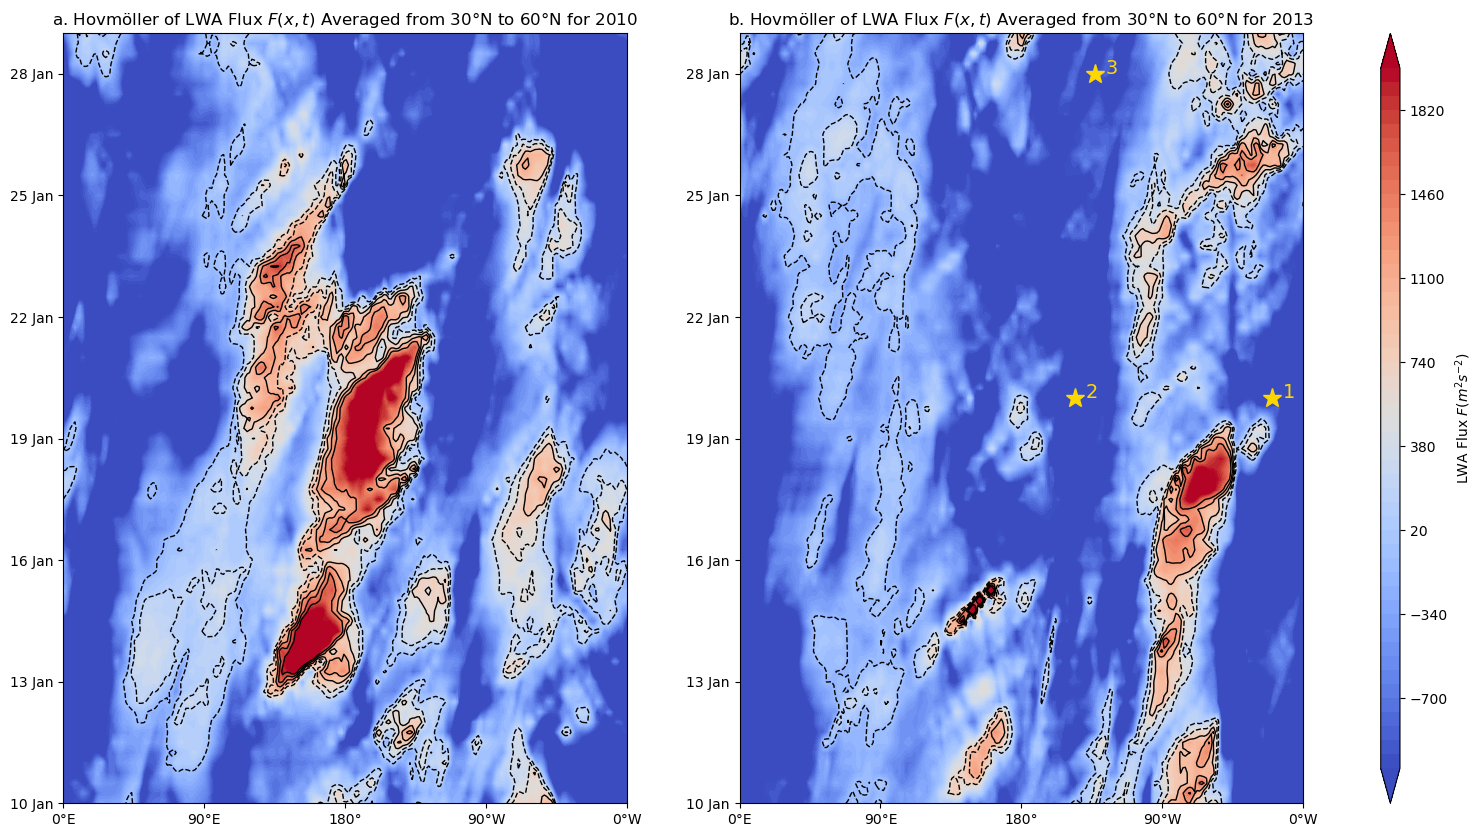

In [6]:
# progress bar ver with contour on LWA hovemoller - final ver fig3

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            return time_stamp, total_flux
    return None, None

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')

    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

    time_ranges = [
        (datetime(2010, 1, 10), datetime(2010, 1, 29)),
        (datetime(2013, 1, 10), datetime(2013, 1, 29))
    ]
    time_delta = timedelta(hours=6)

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes

        # Wrap the loop with tqdm for a progress bar
        for i, time_point in tqdm(enumerate(times), total=len(times), desc="LWA Flux Hovmoller with contour of difference"):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros((121, 240))  
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                nh_avg_flux = np.mean(total_flux[80:101, :], axis=0)
                hovmoller_data[i, :] = nh_avg_flux


        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        cf = ax.contourf(X, Y, hovmoller_data, levels=np.linspace(-1000, 2000, 51), cmap='coolwarm', extend='both')
        # Calculate and plot contours for flux differences
        flux_difference = hovmoller_data - np.mean(flux_capacity_2d[80:101, :], axis=0)  # Assuming avg capacity for contour
        ax.contour(X, Y, flux_difference, levels=[-600, -300, 0, 300, 600], colors='black', linewidths=1)

        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of LWA Flux $F(x,t)$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")

        ytick_step_size = 12
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)
        
    fig.colorbar(cf, ax=axs, location='right', aspect=40, label='LWA Flux $F (m^2s^{-2}$)')
    

    save_path = '/depot/wanglei/etc/KenYan_Traffic_Model/fig3ver0410.png'
    plt.savefig(save_path, dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


LWA Flux Hovmoller with contour of difference: 100%|██████████| 77/77 [00:08<00:00,  8.85it/s]


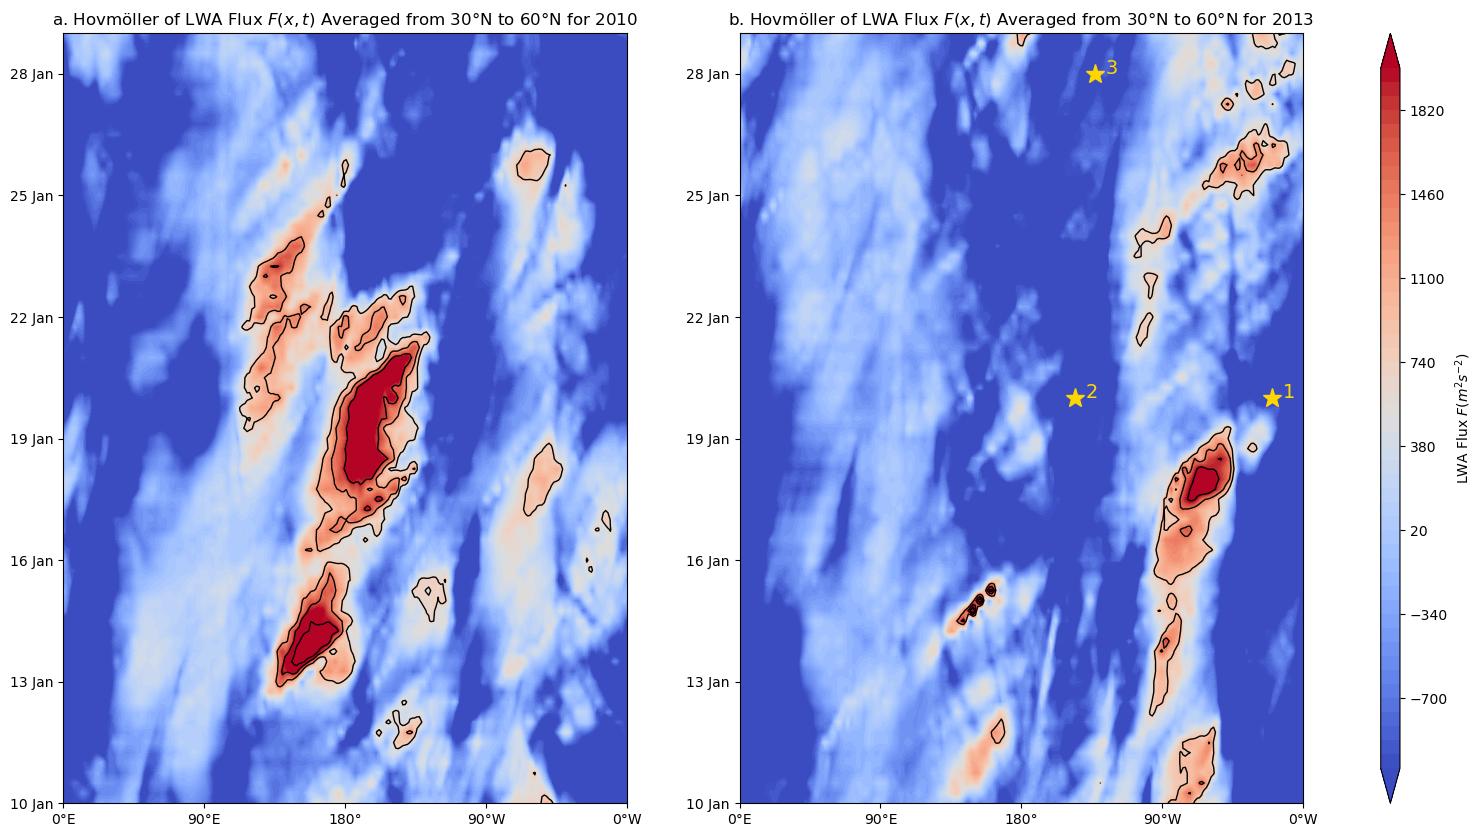

In [2]:
# progress bar ver with contour on LWA hovemoller - final ver fig3

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            return time_stamp, total_flux
    return None, None

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')

    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

    time_ranges = [
        (datetime(2010, 1, 10), datetime(2010, 1, 29)),
        (datetime(2013, 1, 10), datetime(2013, 1, 29))
    ]
    time_delta = timedelta(hours=6)

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes

        # Wrap the loop with tqdm for a progress bar
        for i, time_point in tqdm(enumerate(times), total=len(times), desc="LWA Flux Hovmoller with contour of difference"):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros((121, 240))  
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                nh_avg_flux = np.mean(total_flux[80:101, :], axis=0)
                hovmoller_data[i, :] = nh_avg_flux


        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        cf = ax.contourf(X, Y, hovmoller_data, levels=np.linspace(-1000, 2000, 51), cmap='coolwarm', extend='both')
        # Calculate and plot contours for flux differences
        flux_difference = hovmoller_data - np.mean(flux_capacity_2d[80:101, :], axis=0)  # Assuming avg capacity for contour
        ax.contour(X, Y, flux_difference, levels=[0, 600, 1200], colors='black', linewidths=1)

        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of LWA Flux $F(x,t)$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")

        ytick_step_size = 12
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)
        
    fig.colorbar(cf, ax=axs, location='right', aspect=40, label='LWA Flux $F (m^2s^{-2}$)')
    

    save_path = '/depot/wanglei/etc/KenYan_Traffic_Model/fig3ver0414.png'
    plt.savefig(save_path, dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


LWA Flux Hovmoller with contour of difference: 100%|██████████| 77/77 [00:13<00:00,  5.85it/s]


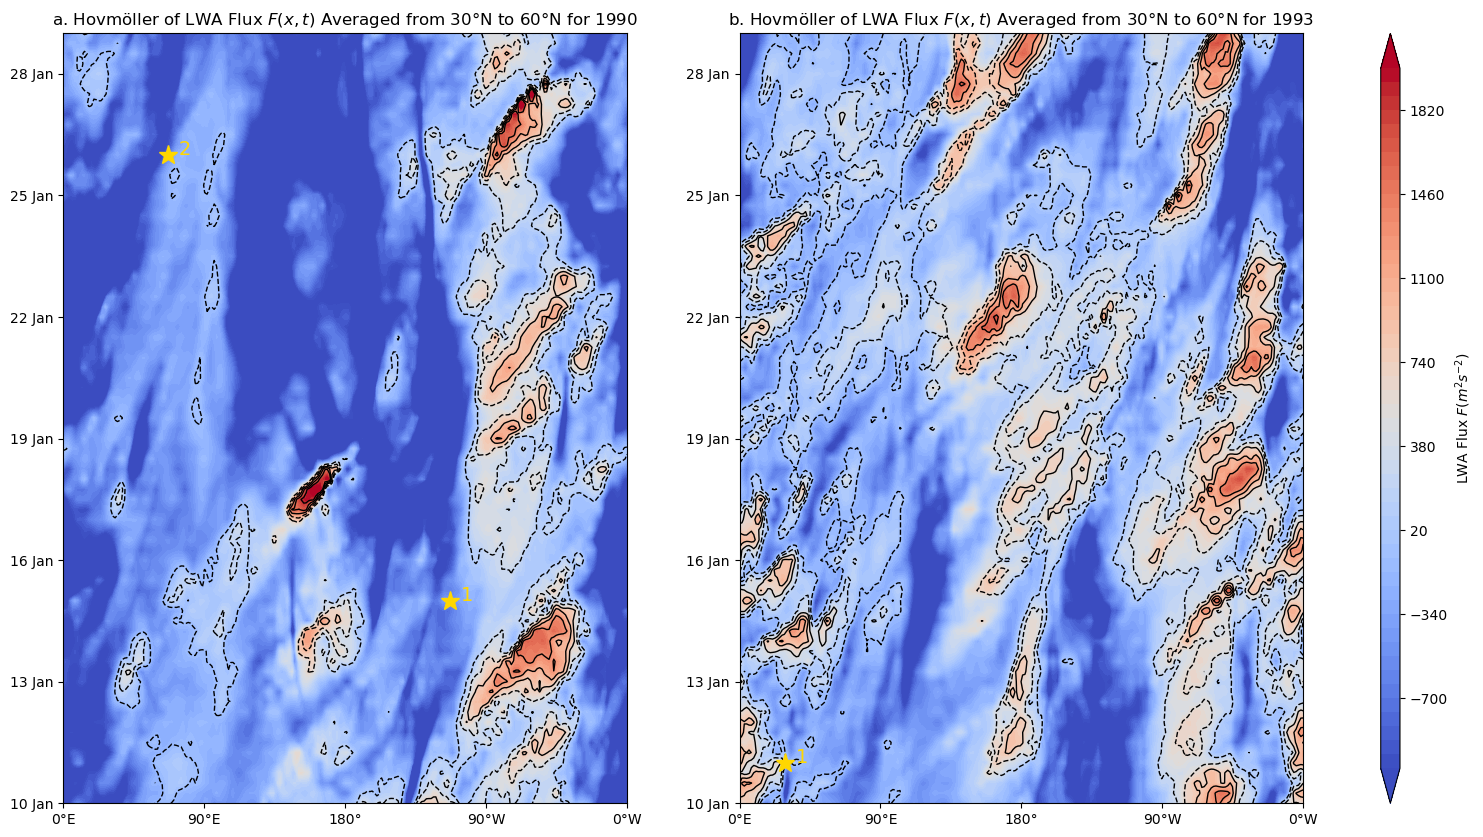

In [1]:
# progress bar ver with contour on LWA hovemoller - other time

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            return time_stamp, total_flux
    return None, None

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')

    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

    time_ranges = [
        (datetime(1990, 1, 10), datetime(1990, 1, 29)),
        (datetime(1993, 1, 10), datetime(1993, 1, 29))
    ]
    time_delta = timedelta(hours=6)

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes

        # Wrap the loop with tqdm for a progress bar
        for i, time_point in tqdm(enumerate(times), total=len(times), desc="LWA Flux Hovmoller with contour of difference"):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros((121, 240))  
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                nh_avg_flux = np.mean(total_flux[80:101, :], axis=0)
                hovmoller_data[i, :] = nh_avg_flux


        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        cf = ax.contourf(X, Y, hovmoller_data, levels=np.linspace(-1000, 2000, 51), cmap='coolwarm', extend='both')
        # Calculate and plot contours for flux differences
        flux_difference = hovmoller_data - np.mean(flux_capacity_2d[80:101, :], axis=0)  # Assuming avg capacity for contour
        ax.contour(X, Y, flux_difference, levels=[-600, -300, 0, 300, 600], colors='black', linewidths=1)

        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of LWA Flux $F(x,t)$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")

        ytick_step_size = 12
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)
        
    fig.colorbar(cf, ax=axs, location='right', aspect=40, label='LWA Flux $F (m^2s^{-2}$)')
    

    save_path = '/depot/wanglei/etc/KenYan_Traffic_Model/fig3ver0410.png'
    plt.savefig(save_path, dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


In [5]:
#ver 0421 check missing data

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm
def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')
    
    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]
    
    time_ranges = [
        (datetime(1983, 12, 1), datetime(1984, 2, 29, 18)),
        (datetime(1984, 12, 1), datetime(1985, 2, 28, 18)),
        (datetime(1985, 12, 1), datetime(1986, 2, 28, 18)),
        (datetime(1986, 12, 1), datetime(1987, 2, 28, 18)),
        (datetime(1987, 12, 1), datetime(1988, 2, 29, 18))
    ]
    time_delta = timedelta(hours=6)
    
    missing_dates = []

    for start_time, end_time in time_ranges:
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        for time_point in times:
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if not matching_files and (time_point.month == 12 or time_point.month == 1):
                missing_dates.append(time_point.strftime('%Y-%m-%d %H:%M'))

    if missing_dates:
        print("Missing data on the following dates/times:")
        for date in missing_dates:
            print(date)
    else:
        print("No missing data detected around the new year transitions.")

if __name__ == "__main__":
    main()


No missing data detected around the new year transitions.


Flux Difference Hovmoller: 100%|██████████| 364/364 [00:47<00:00,  7.63it/s]


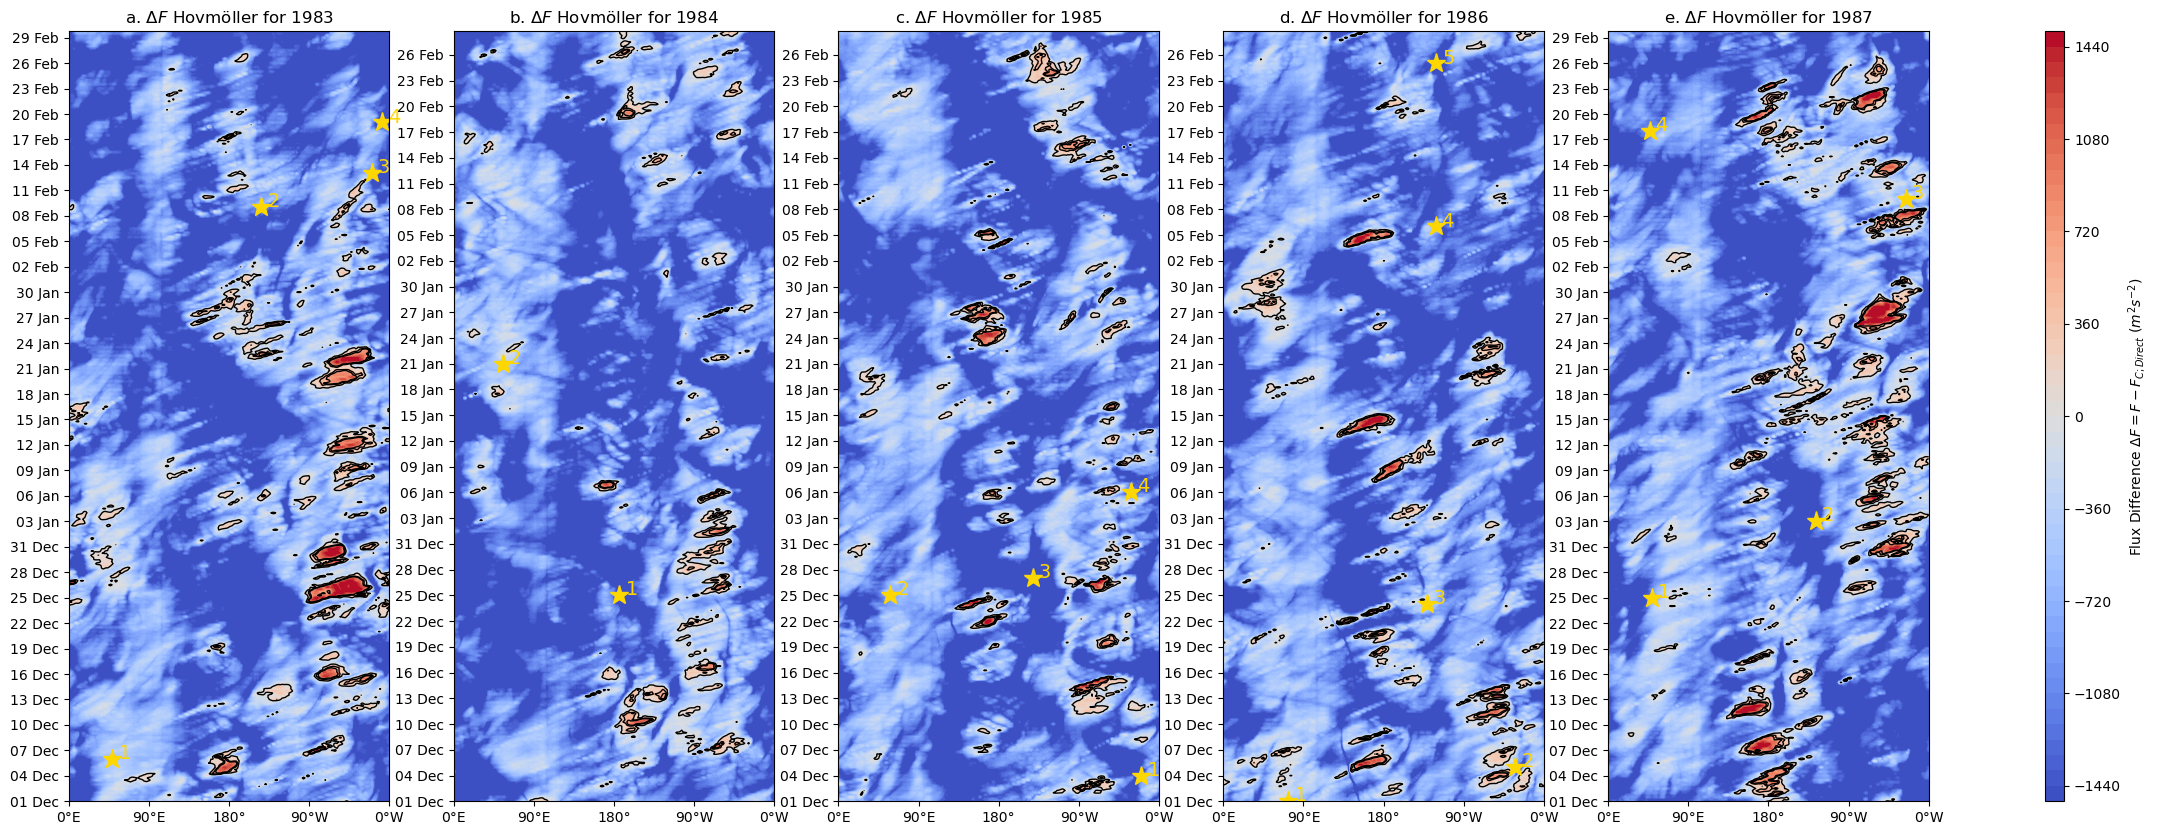

In [6]:
# 0421 version fig 3 - 5 year range

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

# Combine NH and SH blocking data and filter
blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            # return time_stamp, np.clip(total_flux, -1000, 2000)
            return time_stamp, total_flux
    return None, None



def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')
    
    # Collect all valid files once
    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]
    
    # Define two time ranges for Y-axis (6-hour intervals)
    time_ranges = [
        (datetime(1983, 12, 1, 0), datetime(1984, 2, 29, 18)),
        (datetime(1984, 12, 1, 0), datetime(1985, 2, 28, 18)),
        (datetime(1985, 12, 1, 0), datetime(1986, 2, 28, 18)),
        (datetime(1986, 12, 1, 0), datetime(1987, 2, 28, 18)),
        (datetime(1987, 12, 1, 0), datetime(1988, 2, 29, 18))
    ]
    time_delta = timedelta(hours=6)
    
    # Setup the figure and axes for the two subplots without sharing y-axis
    fig, axs = plt.subplots(1, 5, figsize=(30, 10))
    last_contour = None  # Placeholder for the last contour object
    
    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes
        
        for i, time_point in tqdm(enumerate(times), total=len(times), desc="Flux Difference Hovmoller"):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros_like(flux_capacity_2d)
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                if np.any(total_flux):
                    flux_difference = total_flux - flux_capacity_2d
                    nh_avg_flux = np.mean(flux_difference[80:101, :], axis=0)
                    hovmoller_data[i, :] = nh_avg_flux
        hovmoller_data = np.clip(hovmoller_data, -1500, 1500)

        # Plotting the Hovmöller diagram for each subplot
        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        levels = np.linspace(-1500, 1500, 51)
        last_contour = ax.contourf(X, Y, hovmoller_data, levels=levels, cmap='coolwarm', vmin=-1500, vmax=1500)

        ax.contour(X, Y, hovmoller_data, levels=[0, 400, 600], colors='black', linewidths=1)
        
        # Set x-axis labels to specific longitudes
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        
        # Dynamic title setting
        ax.set_title(f"{chr(97 + ax_idx)}. $\\Delta F$ Hovmöller for {start_time.strftime('%Y')}")
   

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

    # Create a colorbar on the right side of the figure, associated with the last subplot
    fig.colorbar(last_contour, ax=axs, location='right', aspect=40, label=r'Flux Difference $\Delta F = F - F_{C; Direct}$ ($m^2s^{-2}$)')
    
    
    # plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



LWA Flux Hovmoller with contour of difference: 100%|██████████| 360/360 [00:04<00:00, 76.58it/s]


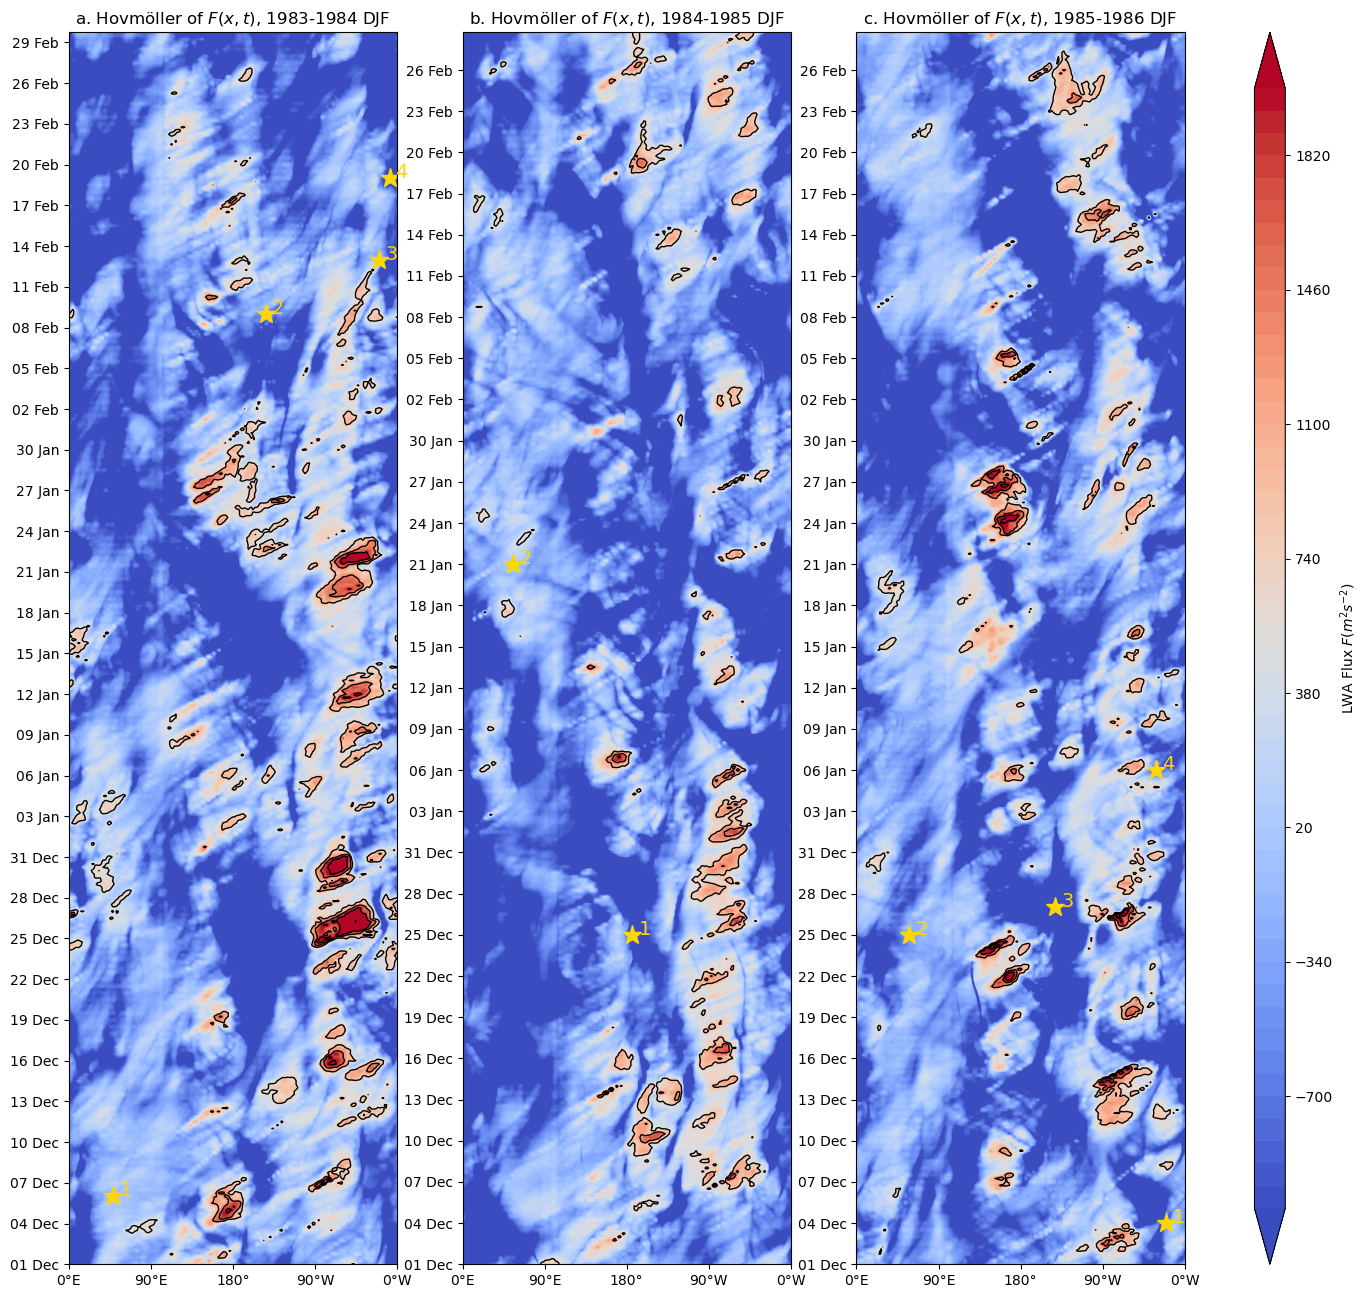

In [4]:
# 0421 version fig 3 - LWA hovmoller, exceedance contour

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime, timedelta
from tqdm import tqdm

output_directory = "/depot/wanglei/etc/KenYan_Traffic_Model/"
blocking_data_NH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0NH.npy")
blocking_data_SH_file = os.path.join(output_directory, "Ka Ying Blocking Data", "BlockingEventDate4.0SH.npy")

blocking_data_NH = np.load(blocking_data_NH_file, allow_pickle=True)
blocking_data_SH = np.load(blocking_data_SH_file, allow_pickle=True)

# Combine NH and SH blocking data and filter
blocking_data = np.vstack((blocking_data_NH, blocking_data_SH))
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    latitude = float(event[3].split(":")[1])
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016 and 30 <= latitude <= 60:
        filtered_blocking_data.append(event)
blocking_data = np.array(filtered_blocking_data)

# Function to load individual flux data
def load_single_flux_data(directory, file_name, pattern):
    if pattern.match(file_name):
        time_stamp = re.search(r'(\d{4}_\d{4}_\d{2}_\d{2}_\d{2})', file_name).group(1)
        f2_file = file_name.replace('F1', 'F2')
        f3_file = file_name.replace('F1', 'F3')

        f1_path = os.path.join(directory, file_name)
        f2_path = os.path.join(directory, f2_file)
        f3_path = os.path.join(directory, f3_file)

        if os.path.exists(f1_path) and os.path.exists(f2_path) and os.path.exists(f3_path):
            flux1 = np.load(f1_path)
            flux2 = np.load(f2_path)
            flux3 = np.load(f3_path)
            total_flux = flux1 + flux2 + flux3
            # return time_stamp, np.clip(total_flux, -1000, 2000)
            return time_stamp, total_flux
    return None, None

def main():
    input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"
    flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy")
    pattern = re.compile(r'F[1-3]_\d{4}_\d{4}_\d{2}_\d{2}_(?:00|06|12|18).npy')

    all_files = [f for f in os.listdir(input_directory) if pattern.match(f)]

    # Define two time ranges for Y-axis (6-hour intervals)
    time_ranges = [
        (datetime(1983, 12, 1, 0), datetime(1984, 2, 29, 18)),
        (datetime(1984, 12, 1, 0), datetime(1985, 2, 28, 18)),
        (datetime(1985, 12, 1, 0), datetime(1986, 2, 28, 18))
        # (datetime(1986, 12, 1, 0), datetime(1987, 2, 28, 18)),
        # (datetime(1987, 12, 1, 0), datetime(1988, 2, 29, 18))
    ]
    time_delta = timedelta(hours=6)

    # Setup the figure and axes for the two subplots without sharing y-axis
    fig, axs = plt.subplots(1, 3, figsize=(18, 16))
    last_contour = None  # Placeholder for the last contour object

    for ax_idx, (start_time, end_time) in enumerate(time_ranges):
        ax = axs[ax_idx]
        times = [start_time + i * time_delta for i in range(int((end_time - start_time) / time_delta) + 1)]
        hovmoller_data = np.zeros((len(times), 240))  # Assuming 240 longitudes

        # Wrap the loop with tqdm for a progress bar
        for i, time_point in tqdm(enumerate(times), total=len(times), desc="LWA Flux Hovmoller with contour of difference"):
            time_stamp = time_point.strftime('%Y_%m_%d_%H')
            matching_files = [f for f in all_files if time_stamp in f]
            if matching_files:
                total_flux = np.zeros((121, 240))  # np.zeros_like(flux_capacity_2d)
                for file_name in matching_files:
                    _, flux_data = load_single_flux_data(input_directory, file_name, pattern)
                    if flux_data is not None:
                        total_flux += flux_data
                nh_avg_flux = np.mean(total_flux[80:101, :], axis=0)
                hovmoller_data[i, :] = nh_avg_flux


        X, Y = np.meshgrid(np.linspace(0, 360, 240), range(len(times)))
        cf = ax.contourf(X, Y, hovmoller_data, levels=np.linspace(-1000, 2000, 51), cmap='coolwarm', extend='both')
        # Calculate and plot contours for flux differences
        flux_difference = hovmoller_data - np.mean(flux_capacity_2d[80:101, :], axis=0)  # Assuming avg capacity for contour
        ax.contour(X, Y, flux_difference, levels=[0, 600, 1200], colors='black', linewidths=1)

        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xticklabels(['0°E', '90°E', '180°', '90°W', '0°W'])
        # ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of LWA Flux $F(x,t)$ Averaged from 30°N to 60°N for {start_time.strftime('%Y')}")
        ax.set_title(f"{chr(97 + ax_idx)}. Hovmöller of $F(x,t)$, {start_time.strftime('%Y')}-{end_time.strftime('%Y')} DJF")

        ytick_step_size = 12
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)

        # Initialize a counter for labeling the stars
        star_counter = 1
        
        # Plot stars for each event
        for event in blocking_data:
            event_date, _, event_lon_str, _ = event
            if start_time <= event_date <= end_time:
                event_lon = int(event_lon_str.split(":")[1])
                x_star = event_lon
                # Adjust the y-coordinate calculation for 6-hour intervals
                y_star_index = int((event_date - start_time).total_seconds() / (6 * 3600))
                ax.plot(x_star, y_star_index, marker='*', markersize=14, color='gold', linestyle='')
                ax.text(x_star + 7, y_star_index, str(star_counter), color='gold', fontsize=14)
                star_counter += 1

        # Adjust y-ticks and y-tick labels to every 3 days
        ytick_step_size = 12  # Every 12 points (3 days) since 4 points per day
        yticks = np.arange(0, len(times), ytick_step_size)
        ax.set_yticks(yticks)
        ytick_labels = [times[tick].strftime('%d %b') for tick in yticks]
        ax.set_yticklabels(ytick_labels, rotation=0)
        
    fig.colorbar(cf, ax=axs, location='right', aspect=40, label='LWA Flux $F (m^2s^{-2}$)')
    # plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()

